In [ ]:
 !pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from pydlm import dlm, trend, seasonality, dynamic
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error

In [57]:
data = pd.read_csv('TSLA.csv')

In [58]:
data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

<ipython-input-58-0ec218d4fe38>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,Open,High,Low,Close,Adj Close,Volume
Open,1.0,0.99971,0.9996,0.99917,0.99917,0.025009
High,0.99971,1.0,0.99961,0.99963,0.99963,0.028913
Low,0.9996,0.99961,1.0,0.99967,0.99967,0.021347
Close,0.99917,0.99963,0.99967,1.0,1.0,0.02598
Adj Close,0.99917,0.99963,0.99967,1.0,1.0,0.02598
Volume,0.025009,0.028913,0.021347,0.02598,0.02598,1.0


In [59]:
df = pd.DataFrame(data)

In [60]:
df = df[['Close','High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [70]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [71]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

In [72]:
from pydlm import dlm, trend, autoReg, dynamic

# Assuming train_data and y_train are already defined

high_feature = []
for price in train_data['High']:
    high_feature.append([price])

# Define the DLM model
myDLM = dlm(y_train)

# Add a linear trend component with prior covariance 1.0
myDLM = myDLM + trend(1, name='lineTrend', w=1.0)

# Add an autoregressive component with a prior covariance of 1e7
myDLM = myDLM + autoReg(degree=1, data=y_train, name='ar1', w=1e7)

# Add a dynamic component with the high_feature
myDLM = myDLM + dynamic(features=high_feature, discount=1, name='High')

# Fit the DLM model
myDLM.fit()

# Print the fitted model
print(myDLM)

/usr/local/lib/python3.10/dist-packages/pydlm/modeler/autoReg.py:75: UserWarning: The data argument in autoReg is deprecated. Please avoid using it.
  warn('The data argument in autoReg is deprecated. Please avoid using it.')


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [73]:
# Quá trình testing, and predict test
x_test= []
for price in test_data['High']:
  x_test.append([price])
print(np.array(x_test).shape)
y_test = np.array(test_data['Close'])
y_test_pred = myDLM.predictN(date = myDLM.n-1, N=len(x_test),featureDict={'High': x_test})
y_test_pred = y_test_pred[0]

(600, 1)


In [74]:
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MAPE:", mape * 100)
print("RMSE:", rmse)

MAE: 4.9283938497050075
MAPE: 2.069284174576717
RMSE: 6.387476973837069


In [75]:
#Quá trình validate, and predict val
y_val = np.array(val_data['High'])
x_val= []
for price in val_data['High']:
  x_val.append([price])
print(type(x_val))
size = test_size + val_size
y_pred_val = myDLM.predictN(featureDict={'High': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]
print(y_pred_val)

<class 'list'>
[294.42917599040385, 268.14825531232987, 265.5817270250754, 257.5668320006363, 237.4515687141464, 242.1242736166252, 230.4711149971812, 229.63849079399003, 219.44209220782307, 212.79026448262815, 212.2777802046808, 205.71430380406514, 210.2722614581222, 213.16157365875821, 208.33256514377632, 217.0979274304892, 209.0500534592249, 202.36558582378134, 202.2174017419839, 201.06466072123936, 212.3995889421203, 217.60666492628303, 220.3620194241532, 214.98113097985214, 216.62539216954025, 224.24891952284506, 213.60748390974945, 207.94284780650406, 211.27770879956648, 195.5791643597812, 183.23222929046412, 185.34142318976663, 180.09416378007055, 186.39163645214157, 184.90391551852048, 190.34052390699796, 181.26111220251596, 175.69082025773164, 175.33638581213012, 166.72530558183286, 161.6800359728491, 175.35388209108976, 175.48872719701168, 178.90047090107328, 176.3628958349533, 185.30641406357245, 188.6255333925316, 185.53148536739644, 180.76967919910192, 173.4727229870312, 1

In [76]:
# Thực hiện dự đoán 30 ngày tiếp theo của feature 'High' dựa trên Linear Regression
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(np.array(train_data.index).reshape(-1,1), train_data['High'])

#Quá trình testing
x_test_LR = np.array(test_data.index).reshape(-1, 1)
y_test_LR = np.array(test_data['High'])
y_pred_LR = LR_model.predict(x_test_LR)

# Quá trình Validate
x_val_LR= np.array(val_data.index).reshape(-1, 1)
y_val_LR = np.array(val_data)
y_pred_val_LR =  LR_model.predict(x_val_LR)

# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

feature_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
feature_next_30_days = LR_model.predict(feature_next_30_days)

print(feature_next_30_days)

[39.06684965 39.0788158  39.09078194 39.10274808 39.11471422 39.12668037
 39.13864651 39.15061265 39.16257879 39.17454493 39.18651108 39.19847722
 39.21044336 39.2224095  39.23437565 39.24634179 39.25830793 39.27027407
 39.28224022 39.29420636 39.3061725  39.31813864 39.33010478 39.34207093
 39.35403707 39.36600321 39.37796935 39.3899355  39.40190164 39.41386778]


In [77]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x = []
for price in feature_next_30_days:
  x.append([price])
print(type(x))
num_dims = np.ndim(x)
print(num_dims)
y_next_30_days = myDLM.predictN(featureDict={'High': x}, N = 30)
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)

<class 'list'>
2
[37.21881358631734, 39.19183277131552, 39.01106851481243, 39.069636338857755, 39.101609174903864, 39.136537291266166, 39.1711370118515, 39.20577322433432, 39.24040538177541, 39.27503798981962, 39.30967054779206, 39.34430311132855, 39.37893567424676, 39.413568237233676, 39.44820080021296, 39.48283336319308, 39.51746592617312, 39.55209848915317, 39.586731052133196, 39.62136361511324, 39.655996178093275, 39.690628741073326, 39.72526130405336, 39.75989386703341, 39.794526430013455, 39.82915899299349, 39.863791555973535, 39.89842411895357, 39.933056681933614, 39.96768924491366]


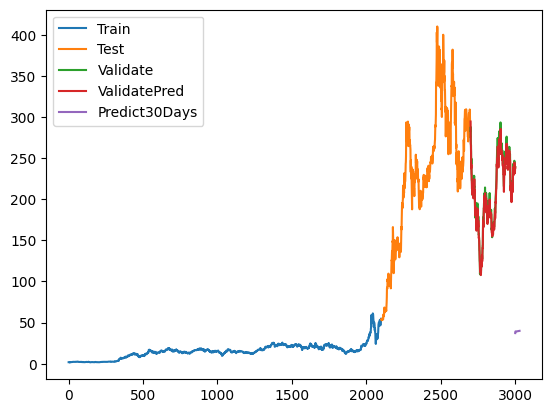

In [78]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index,val_data['Close'])
plt.plot(val_data.index,y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()